# Assessing the ICON-ModEx ML models

## How does the model score change with each ICON-ModEx iteration?
This notebook will harvest the data from the `dynamic-learning-rivers` repository to make a plot showing the evolution of the ML models as more traininig data is added.

## Important behind the scenes information
Here, I am assuming that this notebook is running in a Linux context (e.g. pull a [container that runs a local Jupyter server](https://hub.docker.com/r/jupyter/datascience-notebook) and open the notebook therein). This code will switch branches within a repository that it downloads from GitHub to load the data for side by side comparisions. It will then delete the source repository and retain only the harvested data used for plotting. The harvested data will be saved alongside this notebook here.

## Jumping between Python and R
Working between these two languages can be done cell-by-cell (i.e. `r2py`) or, in this case, notebook by notebook by launching additional "subnotebooks" with `papermill`. We use the latter option here because we want a Python loop to launch a series of R tasks; this is harder to do when all the R must be in a separate cell from the Python.

When installing R tidyverse into the conda environment, there are at least three options:
1. Direct install from CRAN, e.g.:
```
install.packages("tidyverse", repos='http://cran.us.r-project.org', quiet=FALSE, Ncpu=4)
```
2. Conda install from conda-forge:
```
conda install -c conda-forge r-tidyverse
```
3. Conda install from anaconda:
```
conda install -c anaconda r-tidyverse
```
As of July 2024, there are linking (not compile) errors for some of the dependencies in Option 1. Option 1, since it compiles from source, also takes a relatively long time (10's of minutes). Option 2 seemed like the best way to go since thre are many more downloads of those packages than Option 3, but there are some bugs in how the figure domain is set up and communicated to Jupyter thus impacting some plotting routines. Therefore, Option 3 is the only one that worked end-to-end. It could be that the exact version of Python and/or Jupyter that I am using conflicts with Option 2. The hashes differ on some, but not all, of the R packages installed in Options 2 and 3 (i.e. comparing them with `conda list | grep r-`).

In [ ]:
# Run once at start of notebook if these 
# packages are not already installed
! conda install -y -q pandas numpy matplotlib
! conda install -y -q papermill
! conda install -y -q scikit-learn

# Packages needed for R notebook
# Conda install pulls binaries from conda-forge, much faster than
# installing direct from CRAN (and building from source).
# ALso, some packages have linking errors when building 
# from source.

# Install packages from Conda Forge (Option 2, above)
#! conda install -y -q -c conda-forge r-tidyverse
#! conda install -y -q -c conda-forge r-colourpicker
#! conda install -y -q -c conda-forge r-emmeans
#! conda install -y -q -c conda-forge r-ggspatial
#! conda install -y -q -c conda-forge r-spdata
#! conda install -y -q -c conda-forge r-ggpmisc
#! conda install -y -q -c conda-forge r-ggextra
#! conda install -y -q -c conda-forge r-patchwork

# Install packages from Anaconda (Option 3, above)
! conda install -y -q -c anaconda r-tidyverse
! conda install -y -q -c anaconda r-ggextra
! conda install -y -q -c anaconda r-segmented

# Get an environment definition file for reproducibility
# (i.e. you can rebuild this environment with `conda env update --name <env_name> -f icon-modex-scatter-plot-conda-env.yaml`
! conda env export > icon-modex-scatter-plot-conda-env.yaml

In [1]:
import pandas as pd
import numpy as np
import papermill as pm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

Matplotlib is building the font cache; this may take a moment.


## Clone source repository

In [2]:
repo_prefix = '~/tmp/'
repo_org='parallelworks'
repo_name='dynamic-learning-rivers'
repo_url = 'https://github.com/'+repo_org+'/'+repo_name

! mkdir -p {repo_prefix}
! cd {repo_prefix}; git clone {repo_url}

Cloning into 'dynamic-learning-rivers'...
remote: Enumerating objects: 21423, done.
remote: Counting objects: 100% (281/281), done.
remote: Compressing objects: 100% (182/182), done.
remote: Total 21423 (delta 111), reused 247 (delta 95), pack-reused 21142 (from 1)
Receiving objects: 100% (21423/21423), 4.26 GiB | 51.81 MiB/s, done.
Resolving deltas: 100% (11011/11011), done.


## Grab data and save to CSV
Here we want to track the model score over ModEx iterations.

In [3]:
# Functionalize all the data preporatory steps based on the
# branch name.
def prep_data_on_branch(repo_prefix=repo_prefix, repo_name=repo_name, branch_name='main'):
    
    #===============================
    # The following two commands are
    # each independent of each other
    # in that they run in two separate
    # child shells spawned from the
    # main underlying execution shell.
    # This means that the mkdir command
    # is NOT executed within the GitHub
    # repository.
    #=================================
    # Change to the requested branch
    ! cd {repo_prefix}/{repo_name}; git checkout {branch_name}
    
    # Create a working directory for this branch
    ! mkdir -p ./intermediate_branch_data/{branch_name}
    
    # Load data we want to prepare/merge/preprocess
    data_prefix=repo_prefix+'/'+repo_name
    
    # Some of the branches have different amounts of data 
    # available depending on when they were run and which
    # version of the ML model generated the results.
    
    # Special case of reproducing old community
    # meeting results with old ML model
    if branch in ['Dec-2021a']:
        target_name='Respiration_Rate_mg_DO_per_L_per_H'
        
    # Most likely case of new ML model with updating results
    elif branch in [
        'June-2023',
        'Jul-2023',
        'August-2023',
        'Sep-2023',
        'Oct-2023',
        'Nov-2023',
        'Dec-2021a-log10',
        'Dec-2021b-log10',
        'Jul-2022-log10',
        'Aug-2022-log10',
        'Sep-2022-log10',
        'Oct-2022-log10',
        'Nov-2022-log10',
        'Dec-2022-log10',
        'Jan-2023-log10',
        'Feb-2023-log10',
        'Mar-2023-log10',
        'Apr-2023-log10',
        'May-2023-log10',
        'June-2023-log10',
        'Jul-2023-log10',
        'August-2023-log10',
        'Sep-2023-log10',
        'Oct-2023-log10',
        'Nov-2023-log10',
        'Nov-2023-log10-DO-update-correct',
        'baseline_hp_100',
        'baseline_hp_200',
        'baseline_hp_300',
        'baseline_lp_100',
        'baseline_lp_200',
        'baseline_lp_300',
        'pca_hp_100',
        'pca_hp_200',
        'pca_hp_300',
        'pca_lp_100',
        'pca_lp_200',
        'pca_lp_300']:
        target_name='Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'

    # Special case of old ML model
    else:
        target_name='Respiration_Rate_mg_per_L_per_H'
        
    main_input = pd.read_csv(data_prefix+"/scripts/prep_01_output_train.csv")
    avg_output = pd.read_csv(data_prefix+'/scripts/post_01_output_ml_predict_avg.csv')
    std_output = pd.read_csv(data_prefix+'/scripts/post_01_output_ml_predict_std.csv')
    
    # Use Sample_ID as the index so files can be merged on this value
    main_input.set_index('Sample_ID',inplace=True)
    avg_output.set_index('Sample_ID',inplace=True)
    std_output.set_index('Sample_ID',inplace=True)

    # Merge files
    avg_merge = pd.merge(
        main_input,
        avg_output, 
        left_index=True,
        right_index=True,
        suffixes=['_obs','_pre_avg'])
    
    # Add log calculations for use with R notebook
    avg_merge['Log_Observed_Normalized_Respiration_Rate'] = np.log10(np.abs(avg_merge[target_name+'_obs']))
    avg_merge['Log_Predicted_Normalized_Respiration_Rate'] = np.log10(np.abs(avg_merge[target_name+'_pre_avg']))
    
    # Add duplicate columns with uniform target name for
    # use later
    avg_merge['Observed_Normalized_Respiration_Rate'] = avg_merge[target_name+'_obs']
    avg_merge['Predicted_Normalized_Respiration_Rate'] = avg_merge[target_name+'_pre_avg']
    
    # Add percent error
    avg_merge['Observed_RR_percent_error'] = 100.0*np.abs( (
        avg_merge['Observed_Normalized_Respiration_Rate'] - avg_merge['Predicted_Normalized_Respiration_Rate']
    )/avg_merge['Observed_Normalized_Respiration_Rate'])
    
    all_merge = pd.merge(
        avg_merge,
        std_output, 
        left_index=True,
        right_index=True,
        suffixes=['','_pre_std'])

    predict_and_obs_merge = pd.merge(
        avg_output,
        std_output,
        left_index=True,
        right_index=True,
        suffixes=['_pre_avg','_pre_std'])
    
    # Write intermediate output files
    # Name it the same as what the R notebook expects...
    avg_merge.to_csv('intermediate_branch_data/'+branch_name+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv',mode='w')
    all_merge.to_csv('intermediate_branch_data/'+branch_name+'/output_obs_avgpre_stdpre_merged.csv',mode='w')
    predict_and_obs_merge.to_csv('intermediate_branch_data/'+branch_name+'/output_all_sites_avgpre_stdpre_merged.csv',mode='w')

    # Apply filter for points only in CONUS
    ! ./conus_filter.sh ./intermediate_branch_data/{branch_name}

In [4]:
# Start from fresh! Delete any .csv files that may already be here
!rm -f ICON-ModEx_automated_iterations.csv

# Define the threshold for strong/weak respiration rates
respiration_threshold = -500.0 

# List the branches we want to work with
list_branches_scale = [
    'Dec-2021a',
    'Jul-2022',
    'Aug-2022',
    'Sep-2022',
    'Oct-2022',
    'Nov-2022',
    'Dec-2022',
    'Jan-2023',
    'Feb-2023',
    'Mar-2023',
    'ICON-ModEx-v2.1-April-2023-replicate-01',
    'ICON-ModEx-v2.1-April-2023-replicate-02',
    'May-2023',
    'June-2023',
    'Jul-2023',
    'August-2023',
    'Sep-2023',
    'Oct-2023',
    'Nov-2023']

list_branches_log10 = [
    'Dec-2021a-log10',
    'Dec-2021b-log10',
    'Jul-2022-log10',
    'Aug-2022-log10',
    'Sep-2022-log10',
    'Oct-2022-log10',
    'Nov-2022-log10',
    'Dec-2022-log10',
    'Jan-2023-log10',
    'Feb-2023-log10',
    'Mar-2023-log10',
    'Apr-2023-log10',
    'May-2023-log10',
    'June-2023-log10',
    'Jul-2023-log10',
    'August-2023-log10',
    'Sep-2023-log10',
    'Oct-2023-log10',
    'Nov-2023-log10-DO-update-correct']

list_branches_baseline = [
    'baseline_hp_100',
    'baseline_hp_200',
    'baseline_hp_300',
    'baseline_lp_100',
    'baseline_lp_200',
    'baseline_lp_300'
]

list_branches_pca = [
    'pca_hp_100',
    'pca_hp_200',
    'pca_hp_300',
    'pca_lp_100',
    'pca_lp_200',
    'pca_lp_300'
]

# Decompress CONUS outline dataset
! gunzip -c us.xy.gz > us.xy

In [5]:
#=======================================
# Gather data over the standard branches
#=======================================

# Initialize empty dataframe
icon_modex_scale = pd.DataFrame(
    columns=['hold-out-avg','hold-out-std','ntrain'])

for bb,branch in enumerate(list_branches_scale):
    
    # Change to the requested branch
    # We do not need to prep_data_on_branch for the non-log10 branches
    # since we are not plotting the animation of the scatter. But,
    # we do need to do this step to generate the ROC-AUC anyway.
    prep_data_on_branch(
            repo_prefix=repo_prefix, 
            repo_name=repo_name, 
            branch_name=branch)
    #!cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # We want to get the mean and std of the score and plot that vs the number of inputs to train.
    # Each dot will be an ICON-ModEx iteration.
    
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+'/'+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    #holdout_score = pd.read_csv(repo+'/output_data/holdout_score.txt', sep=':')
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    # Some of these points are dropped during training due to
    # missing values. A better measure of the actual number of
    # data points used to train the models is in the 
    # alternative file which is present after all the 
    # preprocessing steps are completed.
    # RAW INPUT
    #input_data = pd.read_csv(repo+'/input_data/ICON-ModEx_Data.csv')
    # PREPROCESSED INPUT
    input_data = pd.read_csv(repo_prefix+'/'+repo_name+'/scripts/prep_06_output_final_train.csv')
    
    # Gather data and force binary classification for ROC-AUC
    #tmp_df = pd.read_csv('intermediate_branch_data/'+branch+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv')
    #y_true = tmp_df['Observed_Normalized_Respiration_Rate'] > respiration_threshold
    #y_score = tmp_df['Predicted_Normalized_Respiration_Rate'] > respiration_threshold
    #roc_auc_score_value = roc_auc_score(y_true,y_score)
    #print(str(roc_auc_score_value))
    
    icon_modex_scale.loc[len(icon_modex_scale.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index)
        #roc_auc_score_value
    ]

Updating files: 100% (511/511), done.
branch 'Dec-2021a' set up to track 'origin/Dec-2021a'.
Switched to a new branch 'Dec-2021a'
Unable to find image 'parallelworks/gmt:latest' locally
latest: Pulling from parallelworks/gmt

9c85623a: Pulling fs layer 
03d09bef: Pulling fs layer 
2b6ffd48: Pulling fs layer 
e8630103: Pulling fs layer 
b75e7078: Pulling fs layer 
1655d959: Pulling fs layer 
fdfeb463: Pull complete .64MB/87.64MBB[7ADigest: sha256:9b4274e2b29d9678583fd5ad1d64cc5cb7c6b830de542d418fd2a3a76399c871
Status: Downloaded newer image for parallelworks/gmt:latest
branch 'Jul-2022' set up to track 'origin/Jul-2022'.
Switched to a new branch 'Jul-2022'
branch 'Aug-2022' set up to track 'origin/Aug-2022'.
Switched to a new branch 'Aug-2022'
branch 'Sep-2022' set up to track 'origin/Sep-2022'.
Switched to a new branch 'Sep-2022'
Updating files: 100% (185/185), done.
branch 'Oct-2022' set up to track 'origin/Oct-2022'.
Switched to a new branch 'Oct-2022'
branch 'Nov-2022' set up to tra

In [6]:
#=====================================
# Gather data over the -log10 branches
#=====================================

# Initialize empty dataframe
icon_modex_log10 = pd.DataFrame(
    columns=['hold-out-avg','hold-out-std','ntrain','roc-auc'])

for bb,branch in enumerate(list_branches_log10):
    
    # Change to the requested branch
    prep_data_on_branch(repo_prefix=repo_prefix, repo_name=repo_name, branch_name=branch)
    #!cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # We want to get the mean and std of the score and plot that vs the number of inputs to train.
    # Each dot will be an ICON-ModEx iteration.
    
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+'/'+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    #holdout_score = pd.read_csv(repo+'/output_data/holdout_score.txt', sep=':')
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    # RAW INPUT (see note above)
    #input_data = pd.read_csv(repo+'/input_data/ICON-ModEx_Data.csv')
    # PREPROCESSED INPUT
    input_data = pd.read_csv(repo_prefix+'/'+repo_name+'/scripts/prep_06_output_final_train.csv')
    
    # Gather data and force binary classification for ROC-AUC
    tmp_df = pd.read_csv('intermediate_branch_data/'+branch+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv')
    y_true = tmp_df['Observed_Normalized_Respiration_Rate'] > respiration_threshold
    y_score = tmp_df['Predicted_Normalized_Respiration_Rate'] > respiration_threshold
    roc_auc_score_value = roc_auc_score(y_true,y_score)
    print(str(roc_auc_score_value))
    
    icon_modex_log10.loc[len(icon_modex_log10.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index),
        roc_auc_score_value
    ]
    
    # We could also grab the histogram of CONUS predictions to check for an evolution of bias over time
    # Grab code from the Figure-2 harvestor notebook if needed.
    # Use Papermill to launch a notebook
    # To list available kernels,
    #   jupyter kernelspec list
    # The working directory was created by prep_data_on_branch
    # The first R kernel execution takes a few extra minutes as
    # necessary R packages are installed on-the-fly during the 
    # first execution of the notebook (but subsequent reruns with
    # the same kernel do not need to reinstall).
    # Wrap this in try: except: because R-plotting raises an error
    # after the plot is made (probably a bounding box issue?)
    # that we can ignore.
    try:
        pm.execute_notebook(
            'make_scatter_plot.ipynb',
            'log_scatter_plot.ipynb',
            parameters=dict(work_dir='./intermediate_branch_data/'+branch),
            kernel_name='ir'
        )
    except:
        print('Caught error in notebook. Keep going...')

Updating files: 100% (399/399), done.
branch 'Dec-2021a-log10' set up to track 'origin/Dec-2021a-log10'.
Switched to a new branch 'Dec-2021a-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.5


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (327/327), done.
branch 'Dec-2021b-log10' set up to track 'origin/Dec-2021b-log10'.
Switched to a new branch 'Dec-2021b-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.7403789659224442


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (344/344), done.
branch 'Jul-2022-log10' set up to track 'origin/Jul-2022-log10'.
Switched to a new branch 'Jul-2022-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.8716436355465678


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


branch 'Aug-2022-log10' set up to track 'origin/Aug-2022-log10'.
Switched to a new branch 'Aug-2022-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.8684186003168389


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
branch 'Sep-2022-log10' set up to track 'origin/Sep-2022-log10'.
Switched to a new branch 'Sep-2022-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9307030183527983


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
branch 'Oct-2022-log10' set up to track 'origin/Oct-2022-log10'.
Switched to a new branch 'Oct-2022-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9353221447873703


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
branch 'Nov-2022-log10' set up to track 'origin/Nov-2022-log10'.
Switched to a new branch 'Nov-2022-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9292808219178081


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


branch 'Dec-2022-log10' set up to track 'origin/Dec-2022-log10'.
Switched to a new branch 'Dec-2022-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.936654403038215


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


branch 'Jan-2023-log10' set up to track 'origin/Jan-2023-log10'.
Switched to a new branch 'Jan-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9299050632911392


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
branch 'Feb-2023-log10' set up to track 'origin/Feb-2023-log10'.
Switched to a new branch 'Feb-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9436677184201936


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


branch 'Mar-2023-log10' set up to track 'origin/Mar-2023-log10'.
Switched to a new branch 'Mar-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9374229589026725


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
branch 'Apr-2023-log10' set up to track 'origin/Apr-2023-log10'.
Switched to a new branch 'Apr-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9291917759659696


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


branch 'May-2023-log10' set up to track 'origin/May-2023-log10'.
Switched to a new branch 'May-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.946021684329034


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


branch 'June-2023-log10' set up to track 'origin/June-2023-log10'.
Switched to a new branch 'June-2023-log10'
0.936957779063042

Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
branch 'Jul-2023-log10' set up to track 'origin/Jul-2023-log10'.
Switched to a new branch 'Jul-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9402564805635822


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
branch 'August-2023-log10' set up to track 'origin/August-2023-log10'.
Switched to a new branch 'August-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9476484336558963


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


branch 'Sep-2023-log10' set up to track 'origin/Sep-2023-log10'.
Switched to a new branch 'Sep-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9442657880718922


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


Updating files: 100% (299/299), done.
branch 'Oct-2023-log10' set up to track 'origin/Oct-2023-log10'.
Switched to a new branch 'Oct-2023-log10'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9399238290548211


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


branch 'Nov-2023-log10-DO-update-correct' set up to track 'origin/Nov-2023-log10-DO-update-correct'.
Switched to a new branch 'Nov-2023-log10-DO-update-correct'


Translator for 'R' language does not support parameter introspection.
Passed unknown parameter: work_dir


0.9260007212405337


Executing:   0%|          | 0/16 [00:00<?, ?cell/s]


Execution halted


In [7]:
#=====================================
# Gather data over the baseline branches
#=====================================

# Initialize empty dataframe
icon_modex_baseline = pd.DataFrame(
    columns=[
        'hold-out-avg','hold-out-std','ntrain','roc-auc',
        'r2_test_avg','r2_test_std','r2_test_ens','hp_or_lp_flag'])

# Same target for all baseline branches
target_name = 'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'

for bb,branch in enumerate(list_branches_baseline):
    
    # Change to the requested branch
    prep_data_on_branch(repo_prefix=repo_prefix, repo_name=repo_name, branch_name=branch)
    #!cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+'/'+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    #holdout_score = pd.read_csv(repo+'/output_data/holdout_score.txt', sep=':')
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    # RAW INPUT (see note above)
    #input_data = pd.read_csv(repo+'/input_data/ICON-ModEx_Data.csv')
    # PREPROCESSED INPUT
    input_data = pd.read_csv(
        repo_prefix+'/'+repo_name+'/scripts/prep_06_output_final_train.csv')
    
    # Gather data and force binary classification for ROC-AUC
    tmp_df = pd.read_csv('intermediate_branch_data/'+branch+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv')
    y_true = tmp_df['Observed_Normalized_Respiration_Rate'] > respiration_threshold
    y_score = tmp_df['Predicted_Normalized_Respiration_Rate'] > respiration_threshold
    roc_auc_score_value = roc_auc_score(y_true,y_score)
    #print(str(roc_auc_score_value))
    
    #---------------------------------------------------------
    # Also we want to do something a little different with the
    # baseline branches - they are evaluated on a truly
    # independent testing set (and not through the Monte
    # Carlo cross-validation that effectively uses all points)
    # So to create a comparable R2, we need to:
    #---------------------------------------------------------
    # 1) Get the respiration rates of the 84 sites in the testing set
    #---------------------------------------------------------
    # Keep it in the DF for now because we want the respiration
    # rates linked to their site ID.
    test_df = pd.read_csv(
        repo_prefix+'/'+repo_name+'/examples/ModEx_reproducibility/hp_lp_training_data_based_on_combined_metric/mp_084.csv.out')
    
    # Use Sample_ID as the index so files can be merged on this value
    test_df.set_index('Sample_ID',inplace=True)
    
    #---------------------------------------------------------
    # 2) Loop over each iteration...
    #---------------------------------------------------------
    r2_score_list = []
    for ll in np.arange(0,10):
        # Extract the predictions at the 84 sites we're using as a baseline
        predict_df = pd.read_csv(repo_prefix+'/'+repo_name+'/ml_models/sl_'+str(ll)+'/sl_predictions.csv')
        
        # Use Sample_ID as the index so files can be merged on this value
        predict_df.set_index('Sample_ID',inplace=True)
        
        # Merge the rows on this predict_df with the rows of the test_df,
        # keeping only the rows that match the test_df. Columns with the
        # same names (in particular the target) will get appended _obs
        # and _pre as in prep_data_on_branch.
        merge_df = pd.merge(
            test_df,
            predict_df, 
            left_index=True,
            right_index=True,
            suffixes=['_obs','_pre'])
        
        # Output dataframe for this ensemble member to check shapes, etc.
        merge_df.to_csv(
            './intermediate_branch_data/'+branch+'/sl_'+str(ll)+'_obs_predict_merge.csv', mode='w')
        
        # Compute the r2_score for that iteration for those 84 sites
        my_r = np.min(np.corrcoef(
            merge_df[target_name+'_obs'],
            merge_df[target_name+'_pre']
        ))
        
        my_r2 = my_r*my_r
        
        # If r2_score is less than 0, set to 0. The magnitude of
        # values less than 0 don't mean anything; they are all
        # just really bad ML models.
        if my_r2 < 0.0:
            my_r2 = 0.0
        
        # Add r2_score to list
        r2_score_list.append(my_r2)
    
    # Find the mean and std of the r2_score over the iterations for the testing set (gray band in plot)
    r2_test_avg = np.mean(r2_score_list)
    r2_test_std = np.std(r2_score_list)
    
    # Find the r2_score of the ensemble mean prediction for the testing set (should fall in the middle of the gray band in plot)
    predict_df = pd.read_csv(repo_prefix+'/'+repo_name+'/scripts/post_01_output_ml_predict_avg.csv')
    predict_df.set_index('Sample_ID',inplace=True)
    merge_df = pd.merge(
            test_df,
            predict_df, 
            left_index=True,
            right_index=True,
            suffixes=['_obs','_pre'])
    merge_df.to_csv(
            './intermediate_branch_data/'+branch+'/ens_obs_predict_merge.csv', mode='w')
    r_test_ens = np.min(np.corrcoef(
        merge_df[target_name+'_obs'],
        merge_df[target_name+'_pre']
    ))
    r2_test_ens = r_test_ens*r_test_ens
    if r2_test_ens < 0:
        r2_test_ens = 0.0
    
    # Set a flag to know whether this is an HP or LP model
    # (for plotting later). Value for LP is 0, HP is 1.
    hp_or_lp_flag = 0
    if ( branch.__contains__('hp') ):
        hp_or_lp_flag = 1
    
    # Write output
    # Dataframe used here was initialized with:
    # columns=['hold-out-avg','hold-out-std','ntrain','roc-auc',
    #          'r2_test_avg','r2_test_std','r2_test_ens','hp_or_lp_flag']
    icon_modex_baseline.loc[len(icon_modex_baseline.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index),
        roc_auc_score_value,
        r2_test_avg,
        r2_test_std,
        r2_test_ens,
        hp_or_lp_flag
    ]
    
# Compare to the hold-out score - is the hold-out at all a reasonable representation of R2 computed with a fully independent data set?

branch 'baseline_hp_100' set up to track 'origin/baseline_hp_100'.
Switched to a new branch 'baseline_hp_100'
branch 'baseline_hp_200' set up to track 'origin/baseline_hp_200'.
Switched to a new branch 'baseline_hp_200'
branch 'baseline_hp_300' set up to track 'origin/baseline_hp_300'.
Switched to a new branch 'baseline_hp_300'
branch 'baseline_lp_100' set up to track 'origin/baseline_lp_100'.
Switched to a new branch 'baseline_lp_100'
Updating files: 100% (289/289), done.
branch 'baseline_lp_200' set up to track 'origin/baseline_lp_200'.
Switched to a new branch 'baseline_lp_200'
branch 'baseline_lp_300' set up to track 'origin/baseline_lp_300'.
Switched to a new branch 'baseline_lp_300'


In [8]:
#=====================================
# Gather data over the pca branches
#=====================================

# Initialize empty dataframe
icon_modex_pca = pd.DataFrame(
    columns=[
        'hold-out-avg','hold-out-std','ntrain','roc-auc',
        'r2_test_avg','r2_test_std','r2_test_ens','hp_or_lp_flag'])

# Same target for all baseline branches
target_name = 'Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'

for bb,branch in enumerate(list_branches_pca):
    
    # Change to the requested branch
    prep_data_on_branch(repo_prefix=repo_prefix, repo_name=repo_name, branch_name=branch)
    #!cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+'/'+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    #holdout_score = pd.read_csv(repo+'/output_data/holdout_score.txt', sep=':')
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    # RAW INPUT (see note above)
    #input_data = pd.read_csv(repo+'/input_data/ICON-ModEx_Data.csv')
    # PREPROCESSED INPUT
    input_data = pd.read_csv(
        repo_prefix+'/'+repo_name+'/scripts/prep_06_output_final_train.csv')
    
    # Gather data and force binary classification for ROC-AUC
    tmp_df = pd.read_csv('intermediate_branch_data/'+branch+'/ICON-ModEx_Combined_Predicted_Observed_Respiration_Rates.csv')
    y_true = tmp_df['Observed_Normalized_Respiration_Rate'] > respiration_threshold
    y_score = tmp_df['Predicted_Normalized_Respiration_Rate'] > respiration_threshold
    roc_auc_score_value = roc_auc_score(y_true,y_score)
    #print(str(roc_auc_score_value))
    
    #---------------------------------------------------------
    # Also we want to do something a little different with the
    # baseline branches - they are evaluated on a truly
    # independent testing set (and not through the Monte
    # Carlo cross-validation that effectively uses all points)
    # So to create a comparable R2, we need to:
    #---------------------------------------------------------
    # 1) Get the respiration rates of the 84 sites in the testing set
    #---------------------------------------------------------
    # Keep it in the DF for now because we want the respiration
    # rates linked to their site ID.
    test_df = pd.read_csv(
        repo_prefix+'/'+repo_name+'/examples/ModEx_reproducibility/hp_lp_training_data_based_on_pca_dist/mp_084.csv.out')
    
    # Use Sample_ID as the index so files can be merged on this value
    test_df.set_index('Sample_ID',inplace=True)
    
    #---------------------------------------------------------
    # 2) Loop over each iteration...
    #---------------------------------------------------------
    r2_score_list = []
    for ll in np.arange(0,10):
        # Extract the predictions at the 84 sites we're using as a baseline
        predict_df = pd.read_csv(repo_prefix+'/'+repo_name+'/ml_models/sl_'+str(ll)+'/sl_predictions.csv')
        
        # Use Sample_ID as the index so files can be merged on this value
        predict_df.set_index('Sample_ID',inplace=True)
        
        # Merge the rows on this predict_df with the rows of the test_df,
        # keeping only the rows that match the test_df. Columns with the
        # same names (in particular the target) will get appended _obs
        # and _pre as in prep_data_on_branch.
        merge_df = pd.merge(
            test_df,
            predict_df, 
            left_index=True,
            right_index=True,
            suffixes=['_obs','_pre'])
        
        # Output dataframe for this ensemble member to check shapes, etc.
        merge_df.to_csv(
            './intermediate_branch_data/'+branch+'/sl_'+str(ll)+'_obs_predict_merge.csv', mode='w')
        
        # Compute the r2_score for that iteration for those 84 sites
        my_r = np.min(np.corrcoef(
            merge_df[target_name+'_obs'],
            merge_df[target_name+'_pre']
        ))
        
        my_r2 = my_r*my_r
        
        # If r2_score is less than 0, set to 0. The magnitude of
        # values less than 0 don't mean anything; they are all
        # just really bad ML models.
        if my_r2 < 0.0:
            my_r2 = 0.0
        
        # Add r2_score to list
        r2_score_list.append(my_r2)
    
    # Find the mean and std of the r2_score over the iterations for the testing set (gray band in plot)
    r2_test_avg = np.mean(r2_score_list)
    r2_test_std = np.std(r2_score_list)
    
    # Find the r2_score of the ensemble mean prediction for the testing set (should fall in the middle of the gray band in plot)
    predict_df = pd.read_csv(repo_prefix+'/'+repo_name+'/scripts/post_01_output_ml_predict_avg.csv')
    predict_df.set_index('Sample_ID',inplace=True)
    merge_df = pd.merge(
            test_df,
            predict_df, 
            left_index=True,
            right_index=True,
            suffixes=['_obs','_pre'])
    merge_df.to_csv(
            './intermediate_branch_data/'+branch+'/ens_obs_predict_merge.csv', mode='w')
    r_test_ens = np.min(np.corrcoef(
        merge_df[target_name+'_obs'],
        merge_df[target_name+'_pre']
    ))
    r2_test_ens = r_test_ens*r_test_ens
    if r2_test_ens < 0:
        r2_test_ens = 0.0
    
    # Set a flag to know whether this is an HP or LP model
    # (for plotting later). Value for LP is 0, HP is 1.
    hp_or_lp_flag = 0
    if ( branch.__contains__('hp') ):
        hp_or_lp_flag = 1
    
    # Write output
    # Dataframe used here was initialized with:
    # columns=['hold-out-avg','hold-out-std','ntrain','roc-auc',
    #          'r2_test_avg','r2_test_std','r2_test_ens','hp_or_lp_flag']
    icon_modex_pca.loc[len(icon_modex_pca.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index),
        roc_auc_score_value,
        r2_test_avg,
        r2_test_std,
        r2_test_ens,
        hp_or_lp_flag
    ]
    
# Compare to the hold-out score - is the hold-out at all a reasonable representation of R2 computed with a fully independent data set?

branch 'pca_hp_100' set up to track 'origin/pca_hp_100'.
Switched to a new branch 'pca_hp_100'
branch 'pca_hp_200' set up to track 'origin/pca_hp_200'.
Switched to a new branch 'pca_hp_200'
branch 'pca_hp_300' set up to track 'origin/pca_hp_300'.
Switched to a new branch 'pca_hp_300'
branch 'pca_lp_100' set up to track 'origin/pca_lp_100'.
Switched to a new branch 'pca_lp_100'
Updating files: 100% (289/289), done.
branch 'pca_lp_200' set up to track 'origin/pca_lp_200'.
Switched to a new branch 'pca_lp_200'
Updating files: 100% (289/289), done.
branch 'pca_lp_300' set up to track 'origin/pca_lp_300'.
Switched to a new branch 'pca_lp_300'


In [9]:
# Example with high resolution images
#! convert -size 1080x1080 -delay 2 -loop 0 *.png output.gif

# Can't use wildcard this b/c lists files alphabetically (i.e. by month 
# name, not month order).
#! convert -delay 2 -loop 0 intermediate_branch_data/*/*.png scatter.gif

# Let's just manually prescribe the order since it's not that many 
# and there are some special cases. Make a temporary symbolic link
# to each file locally and name the links so that they go in the
# exact order of the ModEx iterations. Then, create the animation
# with convert and delete the symbolic links.
for bb,branch in enumerate(list_branches_log10):
    cc = bb + 100
    ! ln -sv intermediate_branch_data/{branch}/scatter.png ./tmp_{cc}.png
    
! convert -delay 100 -loop 0 tmp_*.png scatter.gif
! rm -f tmp_*.png

for bb,branch in enumerate(list_branches_log10):
    cc = bb + 100
    ! ln -sv intermediate_branch_data/{branch}/scatter_no_log.png ./tmp_{cc}.png
    
! convert -delay 100 -loop 0 tmp_*.png scatter_no_log.gif
! rm -f tmp_*.png

'./tmp_100.png' -> 'intermediate_branch_data/Dec-2021a-log10/scatter.png'
'./tmp_101.png' -> 'intermediate_branch_data/Dec-2021b-log10/scatter.png'
'./tmp_102.png' -> 'intermediate_branch_data/Jul-2022-log10/scatter.png'
'./tmp_103.png' -> 'intermediate_branch_data/Aug-2022-log10/scatter.png'
'./tmp_104.png' -> 'intermediate_branch_data/Sep-2022-log10/scatter.png'
'./tmp_105.png' -> 'intermediate_branch_data/Oct-2022-log10/scatter.png'
'./tmp_106.png' -> 'intermediate_branch_data/Nov-2022-log10/scatter.png'
'./tmp_107.png' -> 'intermediate_branch_data/Dec-2022-log10/scatter.png'
'./tmp_108.png' -> 'intermediate_branch_data/Jan-2023-log10/scatter.png'
'./tmp_109.png' -> 'intermediate_branch_data/Feb-2023-log10/scatter.png'
'./tmp_110.png' -> 'intermediate_branch_data/Mar-2023-log10/scatter.png'
'./tmp_111.png' -> 'intermediate_branch_data/Apr-2023-log10/scatter.png'
'./tmp_112.png' -> 'intermediate_branch_data/May-2023-log10/scatter.png'
'./tmp_113.png' -> 'intermediate_branch_data/June

# Load and plot data

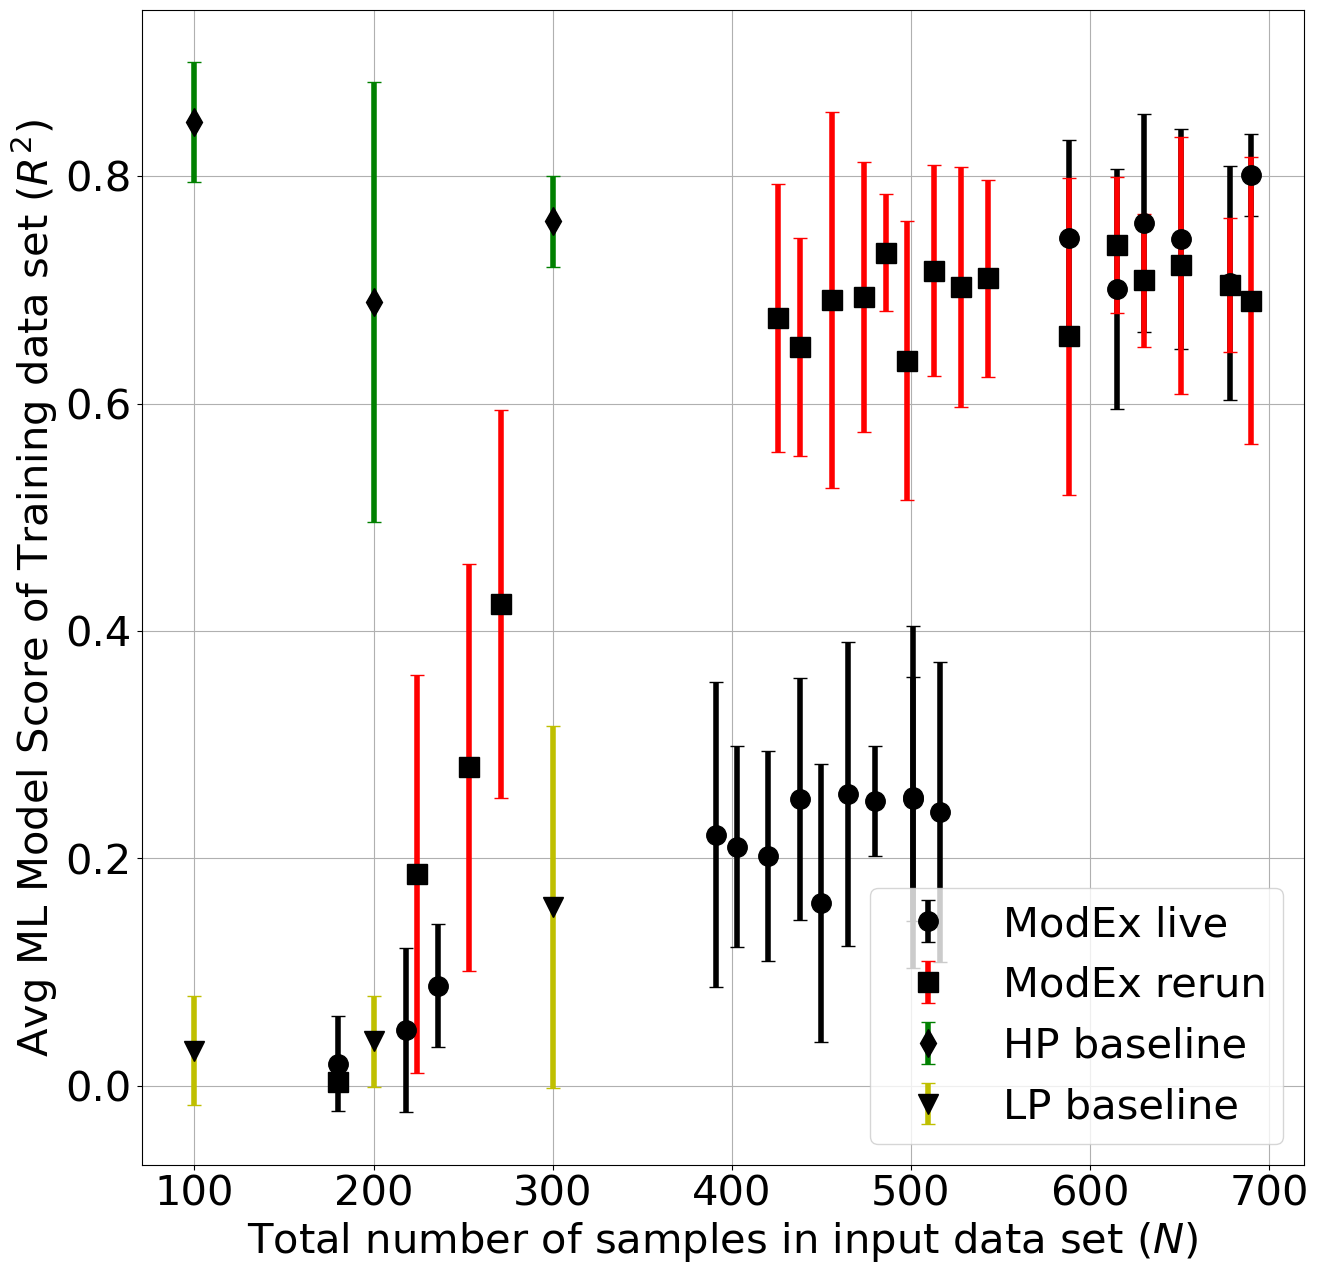

In [10]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Set all font sizes in the plots
font = {'family' : 'sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 30}

mpl.rc('font', **font)

# Plot specs
e_bar_w=4
e_cap_w=5
e_sym_s=14

# Create polygons for background
xy_hp_test = []
xy_hp_test.append([
    icon_modex_baseline['ntrain'][0],
    icon_modex_baseline['r2_test_avg'][0]+icon_modex_baseline['r2_test_std'][0]])
xy_hp_test.append([
    icon_modex_baseline['ntrain'][1],
    icon_modex_baseline['r2_test_avg'][1]+icon_modex_baseline['r2_test_std'][1]])
xy_hp_test.append([
    icon_modex_baseline['ntrain'][2],
    icon_modex_baseline['r2_test_avg'][2]+icon_modex_baseline['r2_test_std'][2]])
xy_hp_test.append([
    icon_modex_baseline['ntrain'][2],
    icon_modex_baseline['r2_test_avg'][2]-icon_modex_baseline['r2_test_std'][2]])
xy_hp_test.append([
    icon_modex_baseline['ntrain'][1],
    icon_modex_baseline['r2_test_avg'][1]-icon_modex_baseline['r2_test_std'][1]])
xy_hp_test.append([
    icon_modex_baseline['ntrain'][0],
    icon_modex_baseline['r2_test_avg'][0]-icon_modex_baseline['r2_test_std'][0]])

xy_lp_test = []
xy_lp_test.append([
    icon_modex_baseline['ntrain'][3],
    icon_modex_baseline['r2_test_avg'][3]+icon_modex_baseline['r2_test_std'][3]])
xy_lp_test.append([
    icon_modex_baseline['ntrain'][4],
    icon_modex_baseline['r2_test_avg'][4]+icon_modex_baseline['r2_test_std'][4]])
xy_lp_test.append([
    icon_modex_baseline['ntrain'][5],
    icon_modex_baseline['r2_test_avg'][5]+icon_modex_baseline['r2_test_std'][5]])
xy_lp_test.append([
    icon_modex_baseline['ntrain'][5],
    icon_modex_baseline['r2_test_avg'][5]-icon_modex_baseline['r2_test_std'][5]])
xy_lp_test.append([
    icon_modex_baseline['ntrain'][4],
    icon_modex_baseline['r2_test_avg'][4]-icon_modex_baseline['r2_test_std'][4]])
xy_lp_test.append([
    icon_modex_baseline['ntrain'][3],
    icon_modex_baseline['r2_test_avg'][3]-icon_modex_baseline['r2_test_std'][3]])

xy_pca_hp_test = []
xy_pca_hp_test.append([
    icon_modex_pca['ntrain'][0],
    icon_modex_pca['r2_test_avg'][0]+icon_modex_pca['r2_test_std'][0]])
xy_pca_hp_test.append([
    icon_modex_pca['ntrain'][1],
    icon_modex_pca['r2_test_avg'][1]+icon_modex_pca['r2_test_std'][1]])
xy_pca_hp_test.append([
    icon_modex_pca['ntrain'][2],
    icon_modex_pca['r2_test_avg'][2]+icon_modex_pca['r2_test_std'][2]])
xy_pca_hp_test.append([
    icon_modex_pca['ntrain'][2],
    icon_modex_pca['r2_test_avg'][2]-icon_modex_pca['r2_test_std'][2]])
xy_pca_hp_test.append([
    icon_modex_pca['ntrain'][1],
    icon_modex_pca['r2_test_avg'][1]-icon_modex_pca['r2_test_std'][1]])
xy_pca_hp_test.append([
    icon_modex_pca['ntrain'][0],
    icon_modex_pca['r2_test_avg'][0]-icon_modex_pca['r2_test_std'][0]])

xy_pca_lp_test = []
xy_pca_lp_test.append([
    icon_modex_pca['ntrain'][3],
    icon_modex_pca['r2_test_avg'][3]+icon_modex_pca['r2_test_std'][3]])
xy_pca_lp_test.append([
    icon_modex_pca['ntrain'][4],
    icon_modex_pca['r2_test_avg'][4]+icon_modex_pca['r2_test_std'][4]])
xy_pca_lp_test.append([
    icon_modex_pca['ntrain'][5],
    icon_modex_pca['r2_test_avg'][5]+icon_modex_pca['r2_test_std'][5]])
xy_pca_lp_test.append([
    icon_modex_pca['ntrain'][5],
    icon_modex_pca['r2_test_avg'][5]-icon_modex_pca['r2_test_std'][5]])
xy_pca_lp_test.append([
    icon_modex_pca['ntrain'][4],
    icon_modex_pca['r2_test_avg'][4]-icon_modex_pca['r2_test_std'][4]])
xy_pca_lp_test.append([
    icon_modex_pca['ntrain'][3],
    icon_modex_pca['r2_test_avg'][3]-icon_modex_pca['r2_test_std'][3]])


fig, ax = plt.subplots(figsize=(15,15))
#==========================================
# Selectively retain the HP/LP baseline/pca
# polygons. These are the model scores computed
# with the full hold out data (the 84 MP "neutral"
# sites that were never used during training)
# and as such the model scores are lower. But the
# overall story is similar for the baseline case: 
# HP sites result in higher scores than LP sites 
# and the difference becomes significant as you 
# add more sites in the training. There does not
# appear to be any significant difference when
# using the HP/LP sites ranked by PCA. In any case,
# remove these from the plot since it's not a
# fair apples-to-apples comparison.
if (False):
    ax.add_collection(
        PatchCollection(
            [Polygon(xy_hp_test, closed=True) ],
            alpha=0.4,
            color='r'))
    ax.add_collection(
        PatchCollection(
            [Polygon(xy_lp_test, closed=True) ],
            alpha=0.4,
            color='k'))
if (False):
    ax.add_collection(
        PatchCollection(
            [Polygon(xy_pca_hp_test, closed=True) ],
            alpha=0.4,
            color='r'))
    ax.add_collection(
        PatchCollection(
            [Polygon(xy_pca_lp_test, closed=True) ],
            alpha=0.4,
            color='k'))

ax.errorbar(
    icon_modex_scale['ntrain'],
    icon_modex_scale['hold-out-avg'],
    icon_modex_scale['hold-out-std'],
    fmt='ko',
    ecolor='k',
    elinewidth=e_bar_w,
    capsize=e_cap_w,
    markersize=e_sym_s)
ax.errorbar(
    icon_modex_log10['ntrain'],
    icon_modex_log10['hold-out-avg'],
    icon_modex_log10['hold-out-std'],
    fmt='ks',
    ecolor='r',
    elinewidth=e_bar_w,
    capsize=e_cap_w,
    markersize=e_sym_s)

# First all the HP points
hp=icon_modex_baseline[icon_modex_baseline['hp_or_lp_flag'] == 1.0]
ax.errorbar(
    hp['ntrain'],
    hp['hold-out-avg'],
    hp['hold-out-std'],
    fmt='kd',
    ecolor='g',
    elinewidth=e_bar_w,
    capsize=e_cap_w,
    markersize=e_sym_s)

# Second all the LP points
hp=icon_modex_baseline[icon_modex_baseline['hp_or_lp_flag'] == 0.0]
ax.errorbar(
    hp['ntrain'],
    hp['hold-out-avg'],
    hp['hold-out-std'],
    fmt='kv',
    ecolor='y',
    elinewidth=e_bar_w,
    capsize=e_cap_w,
    markersize=e_sym_s)

# Comment out the HP/LP PCA points since they
# tell a similar, but less robust, story.
#ax.errorbar(
#    # Artificial offset for visualization
#    icon_modex_pca['ntrain']+10,
#    icon_modex_pca['hold-out-avg'],
#    icon_modex_pca['hold-out-std'],
#    fmt='ys',
#    ecolor='y',
#    elinewidth=3,
#    capsize=5)

#ax.errorbar(
#    icon_modex_baseline['ntrain'],
#    icon_modex_baseline['r2_test_avg'],
#    icon_modex_baseline['r2_test_std'],
#    fmt='cs',
#    ecolor='c',
#    elinewidth=3,
#    capsize=5)
ax.grid()

plt.ylabel('Avg ML Model Score of Training data set ($R^2$)')
plt.xlabel('Total number of samples in input data set ($N$)')
plt.legend(['ModEx live','ModEx rerun','HP baseline','LP baseline'],loc='lower right')
plt.savefig('ICON_ModEx_summary.pdf')

**Figure Caption:** The "live" iterations are the ICON-ModEx ML models that generated the results shared with community members and were used for making decisions of which sites to sample. The hindcast iterations use both the respiration rate normalized with respect to sediment volume and a log10 transform on the targets because both approaches together minimized the bias of the ML models while also increasing the model scores. The big jump in the live iterations is due to the adoption of the normalization of the respiration rate data with respect to the sediment volume and applying the log10 transform in the "production run" of June of 2023 and all subsequent ML model iterations. The hindcast runs all take advantage of the normalization and the log10 transform to provide an apples-to-apples comparision of the progress of the ICON-ModEx iterations had these changes been applied since the very beginning of the study.

In [11]:
icon_modex_baseline

,hold-out-avg,hold-out-std,ntrain,roc-auc,r2_test_avg,r2_test_std,r2_test_ens,hp_or_lp_flag
0,0.847482,0.052767,100.0,0.972222,0.030470,0.027342,0.012471,1.0
1,0.689422,0.193572,200.0,0.951136,0.021688,0.018359,0.017422,1.0
2,0.760256,0.039841,300.0,0.958780,0.115174,0.086389,0.124451,1.0
3,0.030947,0.047955,100.0,0.500000,0.031554,0.044557,0.022801,0.0
4,0.039111,0.039833,200.0,0.500000,0.004256,0.007509,0.001215,0.0
5,0.157108,0.159508,300.0,0.748239,0.006140,0.004775,0.005858,0.0


## Plot the ROC-AUC curve

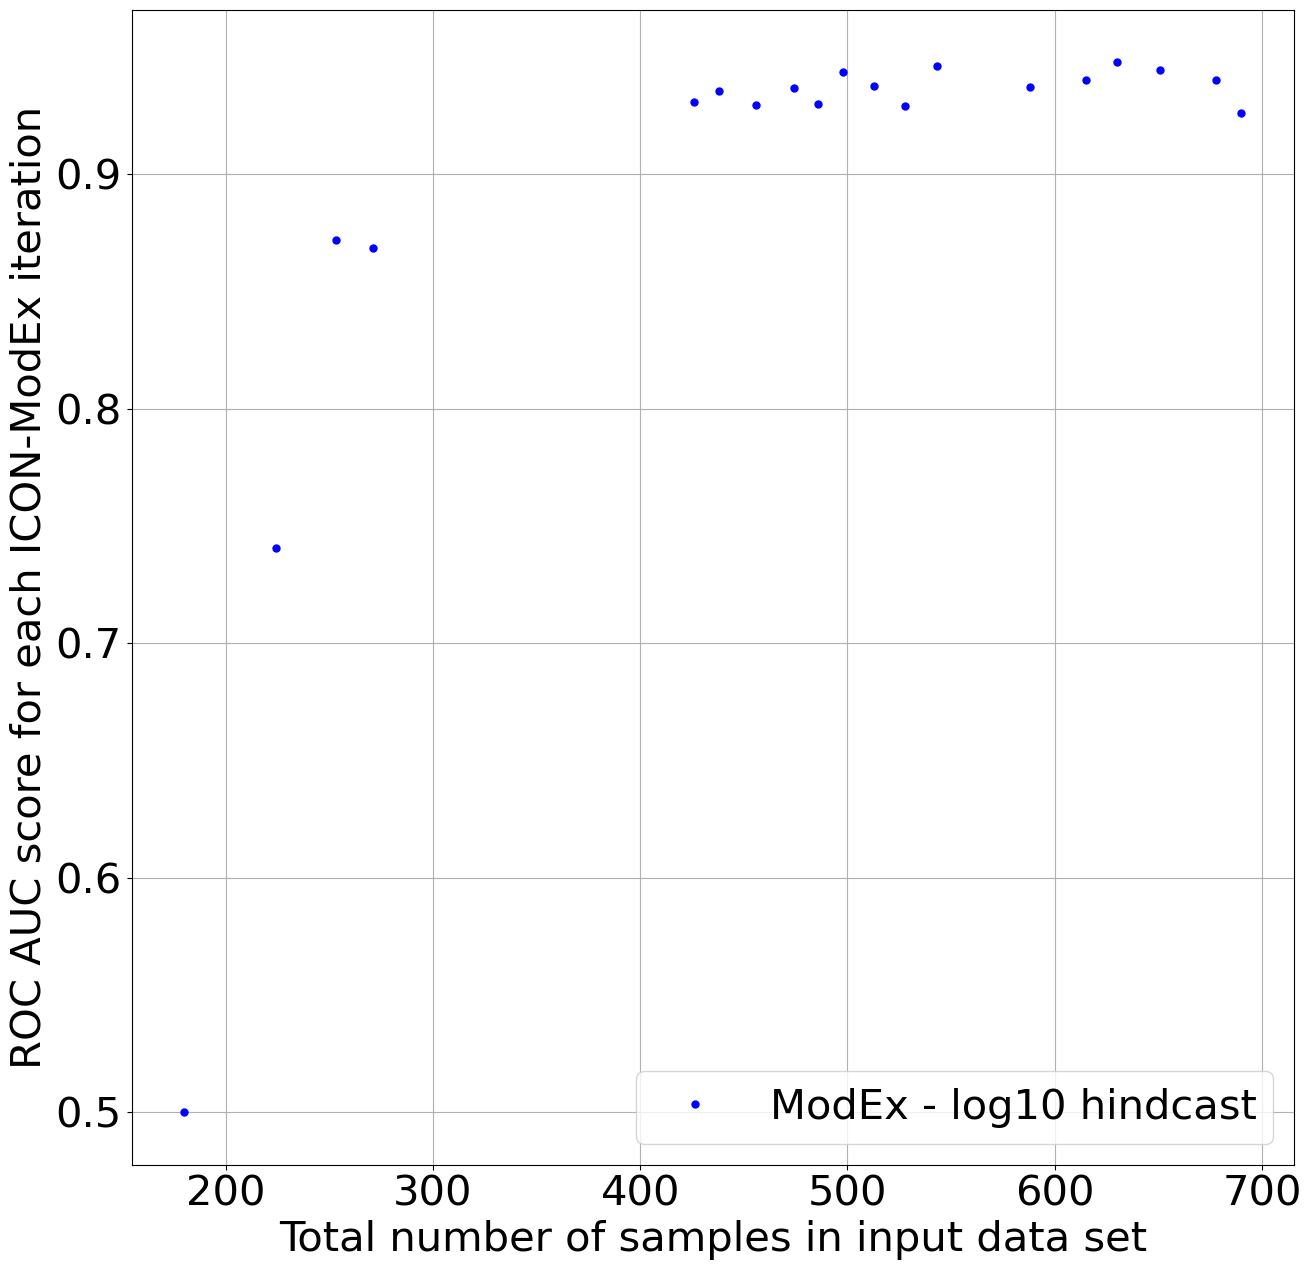

In [12]:
fig, ax = plt.subplots(figsize=(15,15))

# Did not save this data in old archived ML model results
#ax.plot(
#    icon_modex_scale['ntrain'],
#    icon_modex_scale['roc-auc'],'r.')
ax.plot(
    icon_modex_log10['ntrain'],
    icon_modex_log10['roc-auc'],'b.',markersize=10)
ax.grid()

plt.ylabel('ROC AUC score for each ICON-ModEx iteration')
plt.xlabel('Total number of samples in input data set')
plt.legend(['ModEx - log10 hindcast'])
plt.savefig('ICON_ModEx_ROC_AUC.pdf')

# Load and plot simplified version

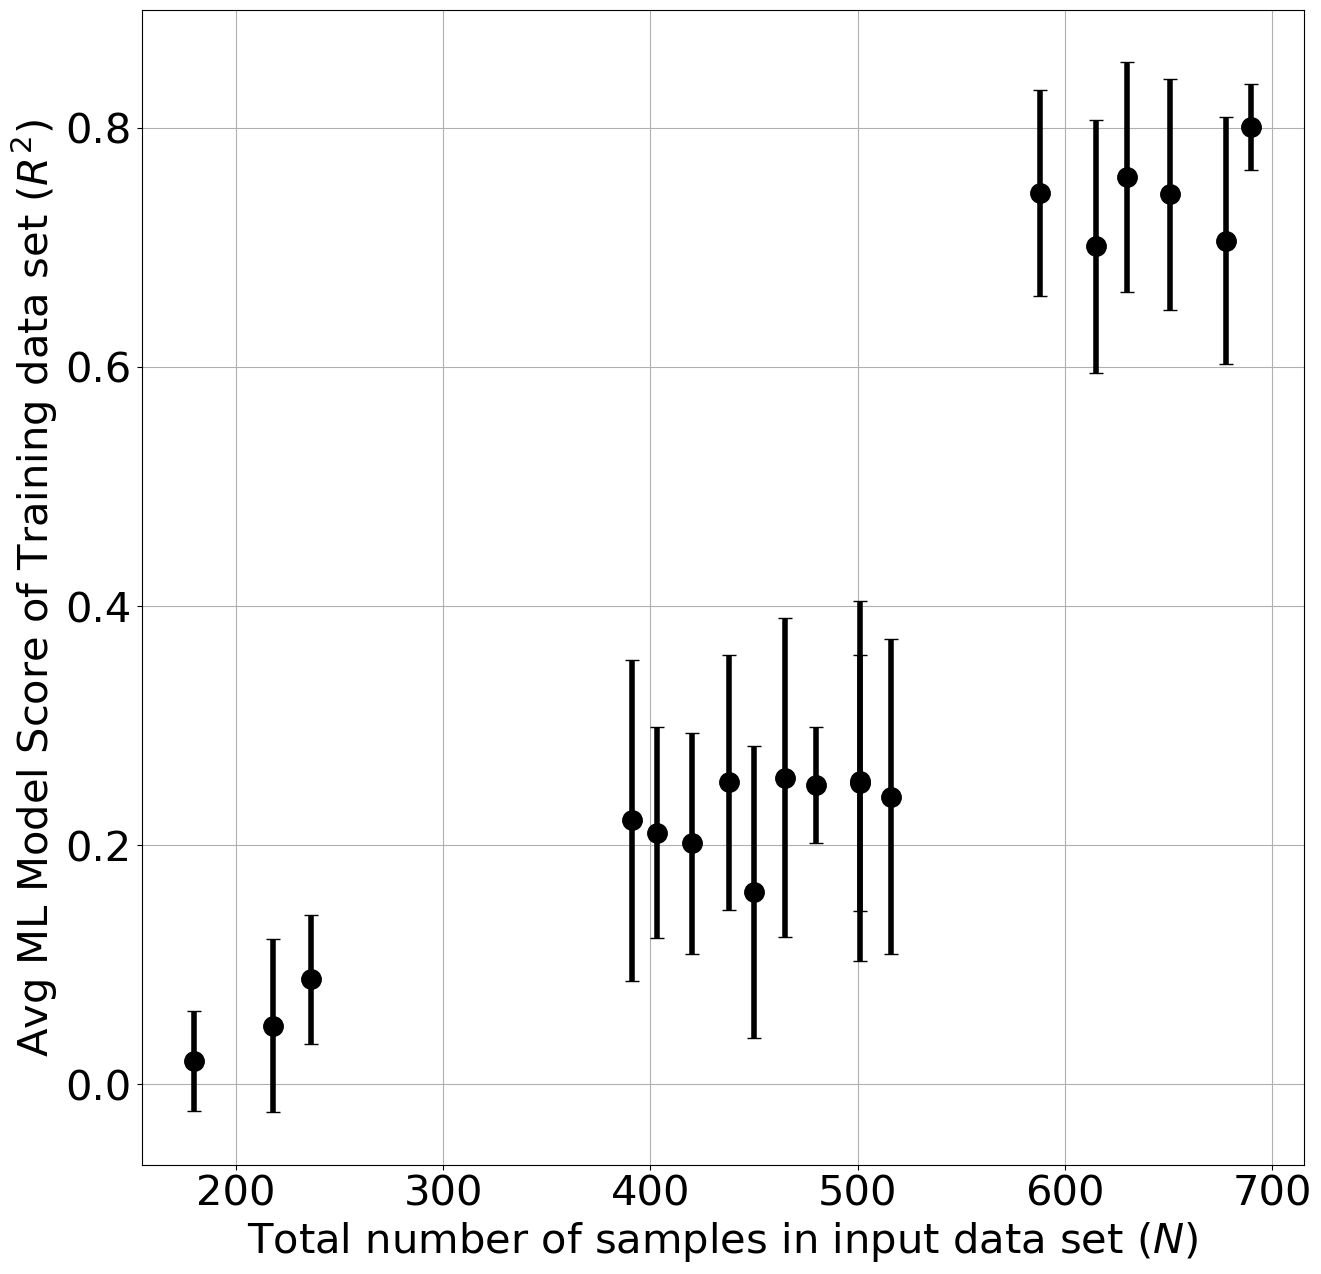

In [13]:
fig, ax = plt.subplots(figsize=(15,15))
ax.errorbar(
    icon_modex_scale['ntrain'],
    icon_modex_scale['hold-out-avg'],
    icon_modex_scale['hold-out-std'],
    fmt='ko',
    ecolor='k',
    elinewidth=e_bar_w,
    capsize=e_cap_w,
    markersize=e_sym_s)
ax.grid()
plt.ylabel('Avg ML Model Score of Training data set ($R^2$)')
plt.xlabel('Total number of samples in input data set ($N$)')
plt.savefig('ICON_ModEx_summary_simplified.pdf')

In [14]:
# Print the R2 values in the simplified plot
pd.set_option('display.max_rows', 500) 
icon_modex_scale

,hold-out-avg,hold-out-std,ntrain
0,0.019529,0.042098,180.0
1,0.049013,0.072297,218.0
2,0.087969,0.053980,236.0
3,0.220767,0.134241,391.0
4,0.210381,0.088214,403.0
5,0.201739,0.092274,420.0
6,0.252584,0.106457,438.0
7,0.160861,0.122112,450.0
8,0.256551,0.133336,465.0
9,0.250437,0.048131,480.0


## Notes on usage of `scikit-learn`'s `roc_auc_score`:
1. The observations (`y`) must be 0 or 1 (i.e. perfect binary classifiers).
2. The predictions can be on a scale from 0 to 1 (i.e. confidence in each classification)
3. In our case, we want to know how well hot spots and cold spots are classified. Ideally, we would not force a threshold (i.e. 500 mg O2/L/hour) - but if we have to force a classification based on the observations, we would then need to figure out some kind of normalization of the predictions to go between 0 and 1. The choice of normalization is also arbitary, so there's no way to avoid some kind of arbitrary thresholding in this analysis.

## Clean up

In [ ]:
# Delete decompressed CONUS outline
! rm -rf us.xy